In [51]:
# Import libraries
import numpy as np
import pandas as pd
# Data Visualization
import seaborn as sn
import matplotlib.pyplot as plt
# K-Means Cluster
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
from sklearn.cluster import KMeans

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#607EAA;
           font-size:250%;
           font-family:serif;
           letter-spacing:0.5px">

<p style="padding: 30px;
          color:white;
          font-size:35px
          ">
<span style="font-family:serif;"> Churn Analysis using Segmentation and Clusters </span>
    
</p>
</div> 


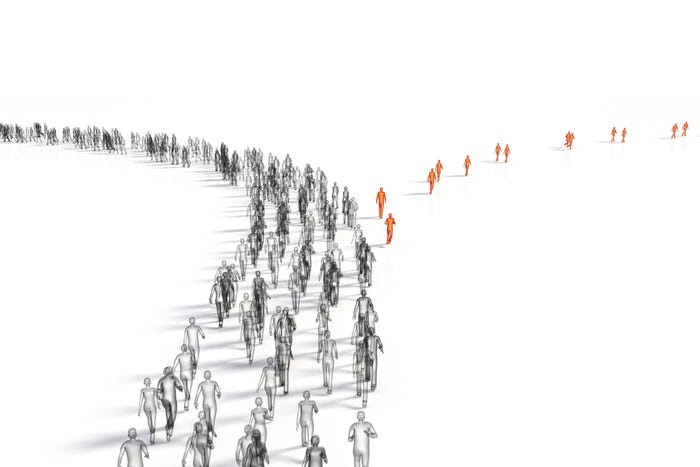


# <span style="font-family:serif;">
**What is Customer Churn?**
Customer churn is the percentage of customers that stopped using your company's product or service during a certain time frame.

**Why is Customer Churn Important?**
A natural process of businesses is that customers will come and go but not all customers are here to stay. For example in the telecom industry, an individual might be there for a few months before churning and trying out a different service. Well, managing and reducing churn rate is important because it costs much more to acquire new customers than i does to retain existing customers.

**How to reduce Churn**
There are many approaches to reduce customer churn but for this project we would attempt to predict which customers are the highest risk of churn by using k-means cluster analysis.
Outline:
- Look at the different variables to see how it affects churn
- Run a K-means cluster analysis
- Profile the different Clusters

Then the company will try to create a marketing mix strategy to minimize the Churn rates in the clusters that are the most susespiable to Churn.  <span style="font-family:serif;">
    

## <span style="font-family:serif;"> **Import Data Set + Clean 🧹** <span style="font-family:serif;">


In [52]:
df = pd.read_csv("../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [53]:
# Inspect Data 
df.head(2)
df["SeniorCitizen"]= df["SeniorCitizen"].map({0: "No", 1: "Yes"})

In [54]:
# Each row represents a customer, each column contains customer’s attributes described on the column Metadata.
df.isnull().sum(axis = 0)

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [55]:
print(f'This dataset contains infomation on {df.shape[0]} customers and {df.shape[1]} attributes, with NO missing values in any columns')

This dataset contains infomation on 7043 customers and 21 attributes, with NO missing values in any columns


## <span style="font-family:serif;">
The data set includes information about:
1. **Services** that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
2. **Customer** account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
3. **Demographic** info about customers – gender, age range, and if they have partners and dependents <span>

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#607EAA;
           font-size:200%;
           font-family:serif;
           letter-spacing:0.5px">

<p style="padding: 30px;
          color:white;
          font-size:30px
          ">
<span style="font-family:serif;"> Visualizing our dataset </span>
    
</p>
</div> 

***

## <span style="font-family:serif;"> **Churn**  <span style="font-family:serif;">

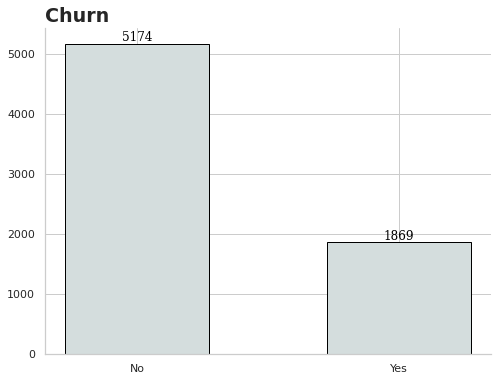

In [56]:
## Output Variable
fig, ax = plt.subplots(1,1, figsize=(8, 6))
data_temp = df['Churn'].value_counts().sort_index()
ax.bar(data_temp.index, data_temp,
          edgecolor='black', color='#d4dddd',
          width=0.55 )
ax.set_title('Churn', loc='left', fontsize=19, fontweight='bold')
for i in data_temp.index:
    ax.annotate(f"{data_temp[i]}", 
                   xy=(i, data_temp[i] + 100),
                   va = 'center', ha='center',fontweight='light', fontfamily='serif',
                   color='black')
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

***

# <span style="font-family:serif;"> **Demographic Variables** <span style="font-family:serif;">

In [57]:
def CountPlot_Table (feature):
    # Create Count Plot for Churn Vs Feature
    sn.countplot(x=feature, hue="Churn", data=df, palette="Paired", edgecolor = 'Black', order=df[feature].value_counts().index)
    sn.despine()
    # Create a plot for proportions
    temp_table = pd.DataFrame(round(df.groupby(feature)['Churn'].value_counts(normalize = True),4))
    table = plt.table(cellText=temp_table.values,
          rowLabels=temp_table.index,
          colLabels=temp_table.columns,
          bbox=(1.5, 0,0.4 , 0.45))
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    plt.show()


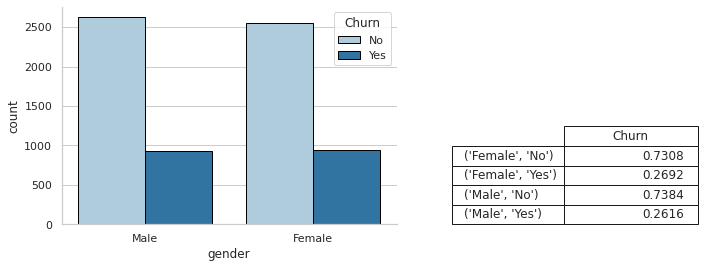

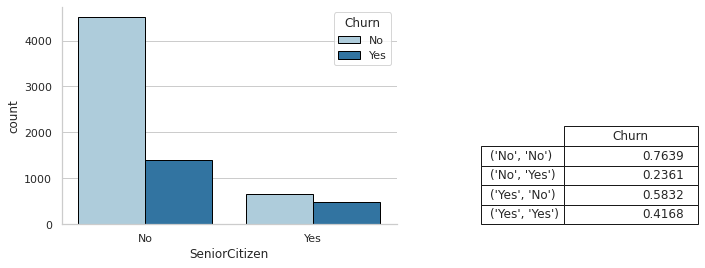

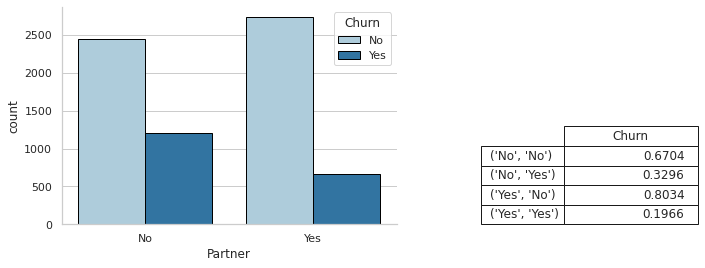

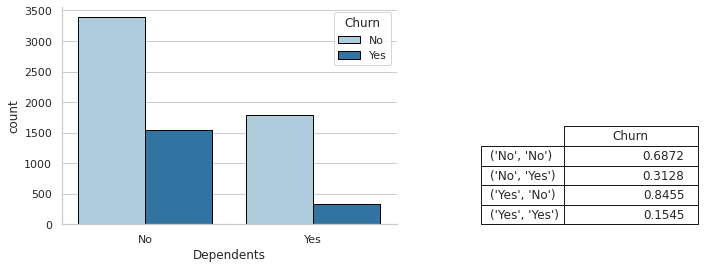

In [58]:
demo_features = ['gender','SeniorCitizen','Partner','Dependents']
for feature in demo_features:
    CountPlot_Table(feature)

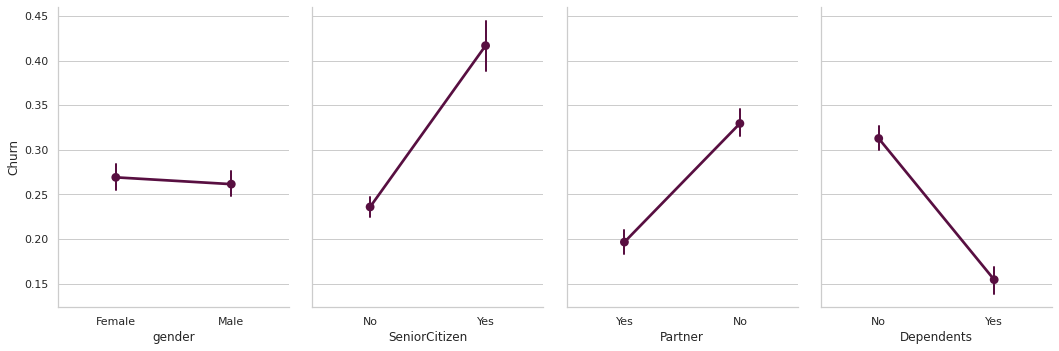

In [59]:
# Churn Rate comparision amongst demographics
df2 =df.copy()
df2["Churn"]= df2["Churn"].map({"No" : 0 , "Yes": 1})
sn.set_theme(style ='whitegrid')
g=sn.PairGrid(df2, y_vars = 'Churn',
             x_vars = ['gender','SeniorCitizen','Partner','Dependents'], height = 5, aspect =0.75)
g.map(sn.pointplot, scale = 1, errwidth =2, color = 'xkcd:plum')


> <span style="font-family:serif;"> 1. **Gender** does *not* seem to play any role in customer Churn
  2. Individuals with **dependents** are less likely to leave the company .
  3. Having a **parnter** and or being a **Senior Citizen** slightly *increases* the odd of an individual leaving the company {Churning}
>> Uneven group sizes comparision might be difficult, should look at proportions to see if there are any significant differences <span style="font-family:serif;">

***

## <span style="font-family:serif;"> **Do these Demographic variables have a statistically significant effect on the churn rates?** <span style="font-family:serif;">

In [60]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

Male_Churn = df2[df2["gender"] == 'Male'].Churn  
Female_Churn = df2[df2["gender"] == 'Female'].Churn

t_statstics = stats.ttest_ind(a= Male_Churn,
                b= Female_Churn,
                equal_var=False)    # Assume samples have equal variance?
t_statstics




Ttest_indResult(statistic=-0.7226104987857616, pvalue=0.4699432354173566)

<span style="font-family:serif;"> To Test whether the difference in Churn Rate is **statisically signgicant**, we would use a two *sample t-test* where the null hypothesis is that the means of both group are the same. <span style="font-family:serif;">
> -  <span style="font-family:serif;"> Ho: $ChurnRate_{Male}$  = $ChurnRate_{Female}$ <span style="font-family:serif;">
> - <span style="font-family:serif;"> Ha: $ChurnRate_{Male}$  != $ChurnRate_{Female}$ <span style="font-family:serif;">
>> <span style="font-family:serif;"> With such a small t-statistics *(-0.722)* and large p_value *(0.4699)*, we would **fail to reject** our null hypothesis and conclude that there is no statistical difference in Churn Rates between genders <span style="font-family:serif;">


In [61]:
Dependents_No = df2[df2["Dependents"] == 'No'].Churn
Dependents_Yes = df2[df2["Dependents"] == 'Yes'].Churn

t_statstics1 = stats.ttest_ind(a= Dependents_No, b= Dependents_Yes, equal_var=False)   
print(t_statstics1)
t_statstics2 = stats.ttest_ind(a= df2[df2["Partner"] == 'No'].Churn, b=  df2[df2["Partner"] == 'Yes'].Churn, equal_var=False)   
print(t_statstics2)
t_statstics3 = stats.ttest_ind(a= df2[df2["SeniorCitizen"] == 'No'].Churn, b=  df2[df2["SeniorCitizen"] == 'Yes'].Churn, equal_var=False)   
print(t_statstics3)


Ttest_indResult(statistic=15.409078802902004, pvalue=2.1775286391572522e-52)
Ttest_indResult(statistic=12.841725043203832, pvalue=2.529114349220257e-37)
Ttest_indResult(statistic=-11.58073209133662, pvalue=9.364391561685353e-30)


> - <span style="font-family:serif;">  Ho: $ChurnRate_{Feature-no}$  = $ChurnRate_{Feature-yes}$  <span style="font-family:serif;">
> - <span style="font-family:serif;"> Ha: $ChurnRate_{Feature-no}$  <>  $ChurnRate_{Feature-yes}$ <span style="font-family:serif;">
> - <span style="font-family:serif;"> Note: One sided t-test -> Reject Null For all three cases, conclude that <span style="font-family:serif;">
>> - <span style="font-family:serif;"> The Churn rate for having no Dependents is **greater** than the Churn Rate for those with dependents . <span style="font-family:serif;">
>> - <span style="font-family:serif;"> The Churn Rate for non-senior citizens is **less** than the churn rate for senior citizens *65+* <span style="font-family:serif;">
>> - <span style="font-family:serif;"> he Churn rate for individuals without parters is **greater** than the churn rate for those with partners <span style="font-family:serif;">


***

# <span style="font-family:serif;"> **Customer account information Visualization** <span style="font-family:serif;">

## <span style="font-family:serif;"> **Payment Method** <span style="font-family:serif;">

Text(0.6, 0.92, 'Payment Method vs Churn')

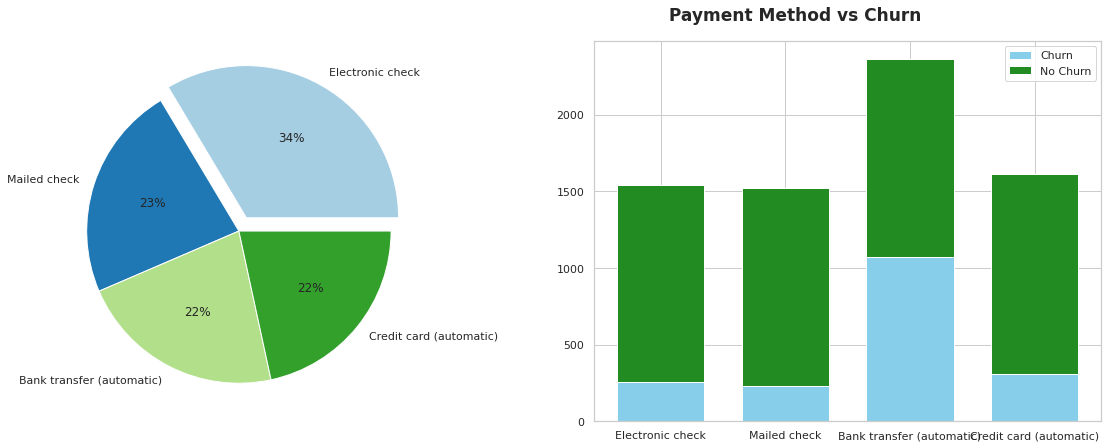

In [62]:
data = df['PaymentMethod'].value_counts()
keys = df['PaymentMethod'].unique()  

# declaring exploding pie
explode = [0.1, 0, 0, 0]
# define Seaborn color palette to use
palette_color = sn.color_palette('Paired')
# plotting data on chart

fig, ax = plt.subplots(1, 2, figsize=(20, 7))
ax[0].pie(data, labels=keys, colors=palette_color,
        explode=explode, autopct='%.0f%%')

# create data

yes_churn = [258, 232, 1071, 308]
no_churn = [1286, 1290,1294, 1304]
ax[1].bar(keys, yes_churn, label='Churn', color = 'skyblue',edgecolor='white', width = 0.7)
ax[1].bar(keys, no_churn, label='No Churn', bottom=yes_churn, color = 'forestgreen', edgecolor='white', width = 0.7)
ax[1].legend()
fig.text(0.60, 0.92, 'Payment Method vs Churn', fontsize=17, fontweight='bold')    

> <span style="font-family:serif;"> *Even* distribution of payment methods, with *Electronic check* being the most popular <span style="font-family:serif;">
>> <span style="font-family:serif;"> Churn Rates consistent amongst different payment method,  **Bank Transfer (automatic)** has the highest Churn Rates <span style="font-family:serif;">

***

## <span style="font-family:serif;"> **Tenure** <span style="font-family:serif;">

Text(0.45, 0.92, 'Tenure vs Churn')

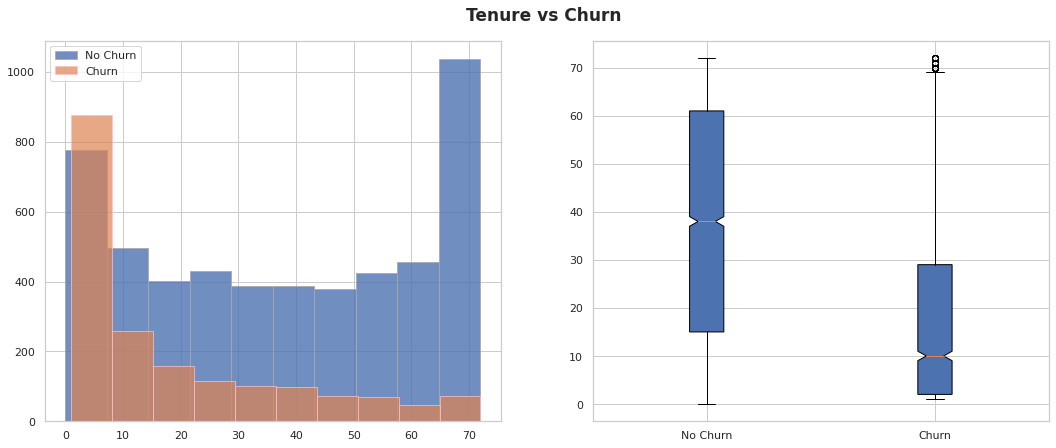

In [63]:
Churn_0 = df2[df2["Churn"] == 0]
Churn_1 = df2[df2["Churn"] == 1]
# plotting first histogram
fig, ax = plt.subplots(1, 2, figsize=(18, 7))
ax[0].hist(Churn_0.tenure, label='No Churn', alpha=.8, edgecolor='darkgrey')
# plotting second histogram
ax[0].hist(Churn_1.tenure, label='Churn', alpha=0.7, edgecolor='pink')
ax[0].legend()  

columns = [Churn_0.tenure, Churn_1.tenure]
ax[1].boxplot(columns, notch=True, patch_artist=True)
plt.xticks([1, 2], ["No Churn", "Churn"])
fig.text(0.45, 0.92, 'Tenure vs Churn', fontsize=17, fontweight='bold') 

<span style="font-family:serif;"> Tenure indicates the total amount of *months* that the customer has been with the company by the end of the quarter specified above.<span style="font-family:serif;">
> <span style="font-family:serif;"> *New customers* are **more** likely to churn whereas older customers are more brand loyal<span style="font-family:serif;">  

***

## <span style="font-family:serif;"> **Contracts** <span style="font-family:serif;">
### <span style="font-family:serif;"> Contracts are highly correlated with tenure so we should suspect a similar pattern<span style="font-family:serif;"> 

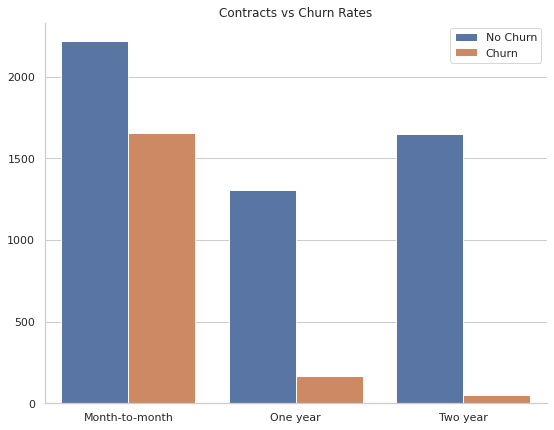

In [64]:
plt.figure(figsize=(9,7))
ax = sn.countplot(x="Contract", hue="Churn", data=df).set(title='Contracts vs Churn Rates', xlabel=None, ylabel = None)
sn.despine()
plt.legend(title='', loc='upper right', labels=['No Churn', 'Churn'])
plt.show(g)

> <span style="font-family:serif;"> Most likely to Churn with **month to month** contract.<span style="font-family:serif;">


***

## <span style="font-family:serif;"> **Monthly Charges** <span style="font-family:serif;">

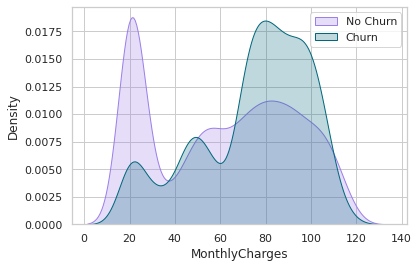

In [65]:
ax = sn.kdeplot(Churn_0.MonthlyCharges, color="#9C7FE8", shade = True)
ax = sn.kdeplot(Churn_1.MonthlyCharges, color="#00677C", shade = True)
ax.legend(["No Churn","Churn"],loc='upper right')

## <span style="font-family:serif;"> **Total Charges** <span style="font-family:serif;">

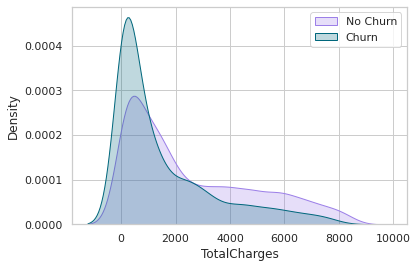

In [66]:
# Total Charges
pd.set_option('mode.chained_assignment', None)
Churn_0['TotalCharges'] = pd.to_numeric(Churn_0['TotalCharges'],errors = 'coerce')
Churn_1['TotalCharges'] = pd.to_numeric(Churn_1['TotalCharges'],errors = 'coerce')

ax = sn.kdeplot(Churn_0.TotalCharges, color="#9C7FE8", shade = True)
ax = sn.kdeplot(Churn_1.TotalCharges, color="#00677C", shade = True)
ax.legend(["No Churn","Churn"],loc='upper right')


<span style="font-family:serif;"> **Monthly Charge** : Indicates the customer’s current total monthly charge for all their services from the company.<span style="font-family:serif;">
> 1. <span style="font-family:serif;"> Customer’s with a **higher** current total monthly charge are **MORE** likely to churn <span style="font-family:serif;">
> 2. <span style="font-family:serif;"> Total charges = Tenure * Monthly Charges. No significant difference in Total Charges for either group <span style="font-family:serif;">

***

## <span style="font-family:serif;"> **Which services or lack of services causes the most Churning?** <span style="font-family:serif;">

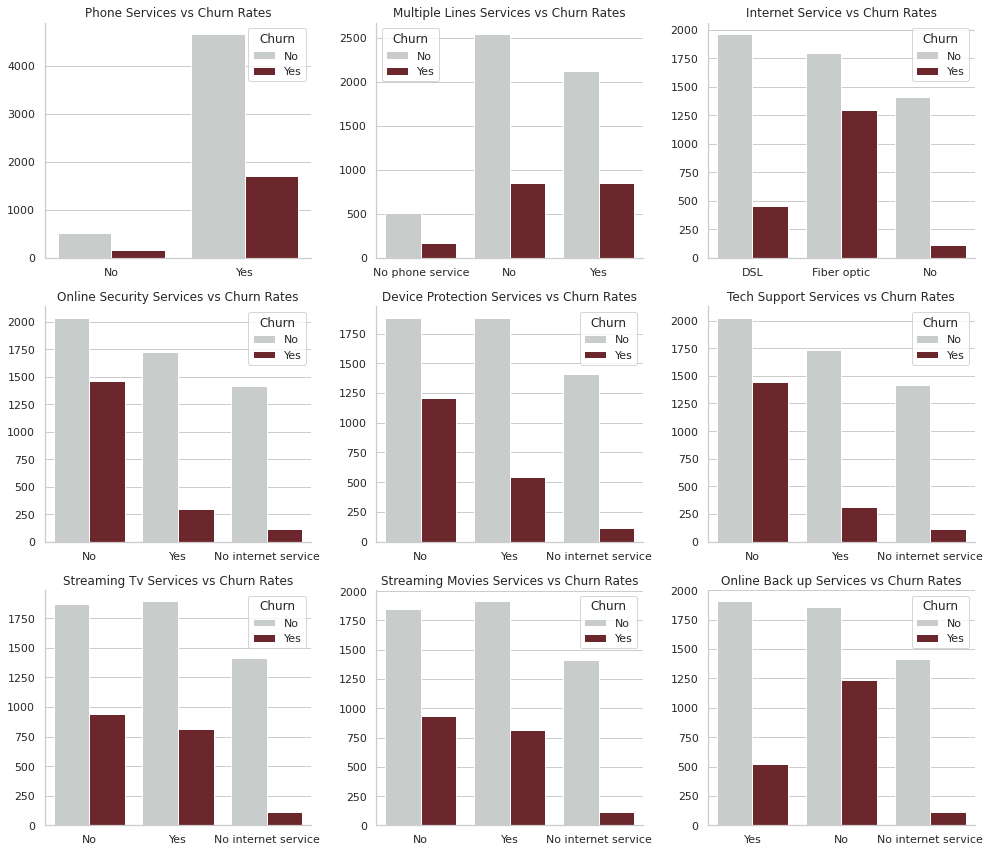

In [67]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14,12))
# Gray for No Churn, highlight Churn!
colors = ["#C7CDCB", "#781B24"]
# Set custom color palette
sn.set_palette(sn.color_palette(colors))
# Graphing
sn.countplot(x="PhoneService", hue="Churn", data=df, ax=axes[0,0]).set(title='Phone Services vs Churn Rates', xlabel=None, ylabel = None)
sn.countplot(x="MultipleLines", hue="Churn", data=df, ax=axes[0,1]).set(title='Multiple Lines Services vs Churn Rates', xlabel=None, ylabel = None)
sn.countplot(x="InternetService", hue="Churn", data=df, ax=axes[0,2]).set(title='Internet Service vs Churn Rates', xlabel=None, ylabel = None)
sn.countplot(x="OnlineSecurity", hue="Churn", data=df, ax=axes[1,0]).set(title='Online Security Services vs Churn Rates', xlabel=None, ylabel = None)
sn.countplot(x="DeviceProtection", hue="Churn", data=df, ax=axes[1,1]).set(title='Device Protection Services vs Churn Rates', xlabel=None, ylabel = None)
sn.countplot(x="TechSupport", hue="Churn", data=df, ax=axes[1,2]).set(title='Tech Support Services vs Churn Rates', xlabel=None, ylabel = None)
sn.countplot(x="StreamingTV", hue="Churn", data=df, ax=axes[2,0]).set(title='Streaming Tv Services vs Churn Rates', xlabel=None, ylabel = None)
sn.countplot(x="StreamingMovies", hue="Churn", data=df, ax=axes[2,1]).set(title='Streaming Movies Services vs Churn Rates', xlabel=None, ylabel = None)
sn.countplot(x="OnlineBackup", hue="Churn",data=df, ax=axes[2,2]).set(title='Online Back up Services vs Churn Rates', xlabel=None, ylabel = None)
sn.despine()
plt.tight_layout()
plt.show()



***

## <span style="font-family:serif;"> Insights
> - <span style="font-family:serif;"> **No** **Security Services**, **Device Protection**, **Tech support**, **Online Backup** *increases* the Churn Rates <span style="font-family:serif;">
> - <span style="font-family:serif;"> Individuals with **Fiber Optic** churn **More** compared to ones using DSL <span style="font-family:serif;">


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#607EAA;
           font-size:200%;
           font-family:serif;
           letter-spacing:0.5px">

<p style="padding: 10px;
          color:white;
          font-size: 30px">
     The Analytics of Segmentation, and Cluster Analysis
</p>
</div> 

<span style="font-family:serif; font-size:20px"> **Segmentation**<span style="font-family:serif;font-size:20px">
- <span style="font-family:serif;"> Segmentation means dividing the total market of customers into smaller, relatively homogeneous groups. This phase stives to group individuals in a way such that those inside each group share similar feature(s). <span style="font-family:serif;">
- <span style="font-family:serif;"> This is useful because marketers goal is to increase number of sales, and to do so they would need to create a customized a marketing strategy for every indiviudal, which isn't practical nor possible! <span style="font-family:serif;">
   - <span style="font-family:serif;"> The next best thing is to group individuals in to similar groups to reduce the number of marketing strateigies all the while reaching the most amount of people! <span style="font-family:serif;">
> <span style="font-family:serif;"> To do so, marketing analysts uses **Cluster Analysis** to group customers in a way that minimizes variance within-clusters, and maximizing variance between clusters <span style="font-family:serif;">



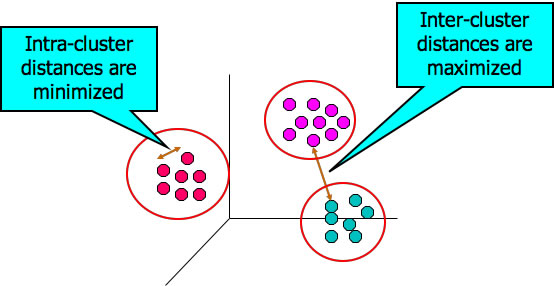


- <span style="font-family:serif;">In our study, we want to minimize Churn Rates. Therefore We will group individuals in to clusters, and profile them <span style="font-family:serif;">
   - <span style="font-family:serif;"> Find out clusters with noticably higher Churn Rates so that the business is able to create marketing strategies to retain those individuals within the clusters <span style="font-family:serif;">


***

#  <span style="font-family:serif;"> Cluster Analysis : 
1. <span style="font-family:serif;"> Prepare Data for Cluster Analysis. Scale numeric values, encode cateogorical. <span style="font-family:serif;">
   - <span style="font-family:serif;"> StandardScaler function = $ Z = (X_i - \mu) / \sigma $ <span style="font-family:serif;">
   - <span style="font-family:serif;"> encode cateogorical turn cateogories in to numbers [0,1,2...] <span style="font-family:serif;">
2. <span style="font-family:serif;"> Run k-means clusters. K clusters based off elbow plot <span style="font-family:serif;">
3. <span style="font-family:serif;"> Profile Clusters <span style="font-family:serif;">

In [68]:
## 1) Prepare Data
df_cluster = df.copy()
df_cluster = df_cluster.drop(['customerID', 'TotalCharges'], axis=1)
## Scale Tenure and Monthly Charges
scaler = StandardScaler()
df_cluster[['tenure', 'MonthlyCharges']] = scaler.fit_transform(df_cluster[['tenure', 'MonthlyCharges']])

#Selecting all variables except tenure and Monthly Charges
df_cluster[df_cluster.columns[~df_cluster.columns.isin(['tenure','MonthlyCharges'])]] = encoder.fit_transform(df_cluster[df_cluster.columns[~df_cluster.columns.isin(['tenure','MonthlyCharges'])]])

In [69]:
## 2) K-Means Clusters
def optimise_k_means(data, max_k):
    means = []
    inertias = []
    
    for k in range(1,max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        means.append(k)
        inertias.append(kmeans.inertia_)
        
    fig = plt.subplots(figsize=(10, 7))
    plt.plot(means, inertias, 'o-', color = 'black')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()

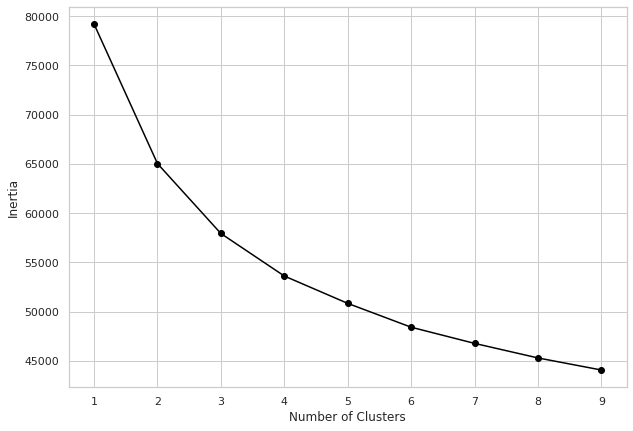

In [70]:
optimise_k_means(df_cluster, 10)

> <span style="font-family:serif;"> **4** Cluster seems to be optimal <span style="font-family:serif;">

In [71]:
# K-Means cluster analysis
kmeans = KMeans(n_clusters = 4,  random_state=10)
kmeans.fit(df_cluster)
# Save cluster group as a column value in our data_frame
df_cluster['Cluster'] = kmeans.labels_

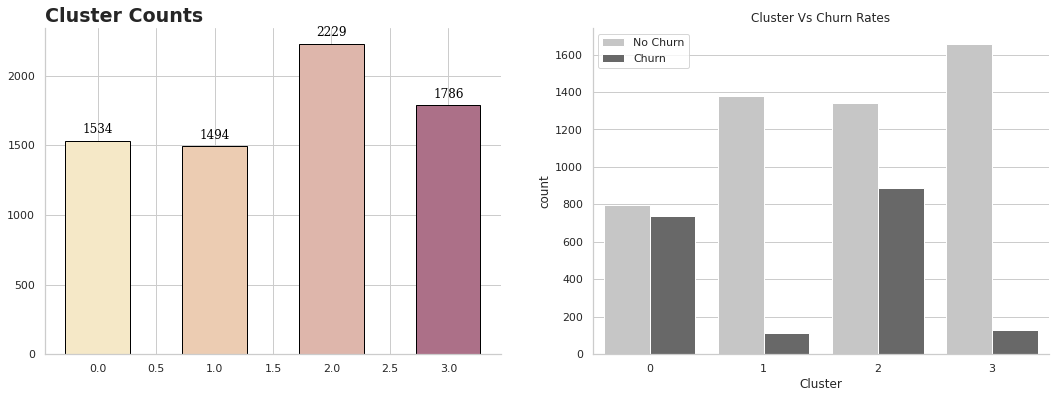

In [72]:
# Cluster Counts
fig, ax = plt.subplots(1,2, figsize=(18, 6))
data_temp = df_cluster['Cluster'].value_counts().sort_index()
ax[0].bar(data_temp.index, data_temp,
          edgecolor='black', color=['#F5E8C7', '#ECCCB2', '#DEB6AB', '#AC7088']
       ,width=0.55 )
ax[0].set_title('Cluster Counts', loc='left', fontsize=19, fontweight='bold')
for i in data_temp.index:
    ax[0].annotate(f"{data_temp[i]}", 
                   xy=(i, data_temp[i] + 80),
                   va = 'center', ha='center',fontweight='light', fontfamily='serif',
                   color='black')
for s in ['top', 'right']:
    ax[0].spines[s].set_visible(False)
    
    
sn.countplot(x='Cluster', hue="Churn", palette="Greys", data=df_cluster)
sn.despine()
plt.legend(title='', loc='upper left', labels=['No Churn', 'Churn'])
plt.title("Cluster Vs Churn Rates")
plt.show()
    


> - <span style="font-family:serif;"> Good even distriubtion of sample size within each clusters !<span style="font-family:serif;">
> - <span style="font-family:serif;"> **Clusters 0 and 2** have a **higher Churn Rate** compared to **Cluster 1 and 3** <span style="font-family:serif;">

***

# <span style="font-family:serif;"> **Profiling Clusters** <span style="font-family:serif;">

## <span style="font-family:serif;"> Question for Businesses. Why are indivudals in Cluster 1 and 2 Churning more often than the other Clusters:<span style="font-family:serif;">
> <span style="font-family:serif;"> There are many variables in this dataset hence many notable differences attributing to the Churning. I will visualize a few important ones we noted in our EDA <span style="font-family:serif;"> 
 
    

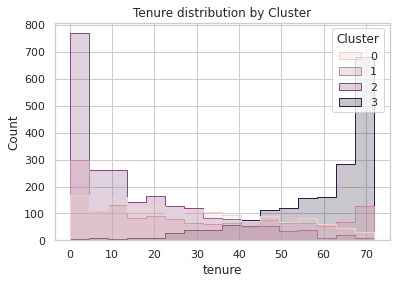

In [73]:
df['Cluster'] = df_cluster['Cluster']
sn.histplot(data=df, x="tenure", hue="Cluster", element="step")
plt.title('Tenure distribution by Cluster')
plt.show()




> <span style="font-family:serif;"> Cluster 0 and 2 have shorter tenure compared to the other clusters <span style="font-family:serif;">

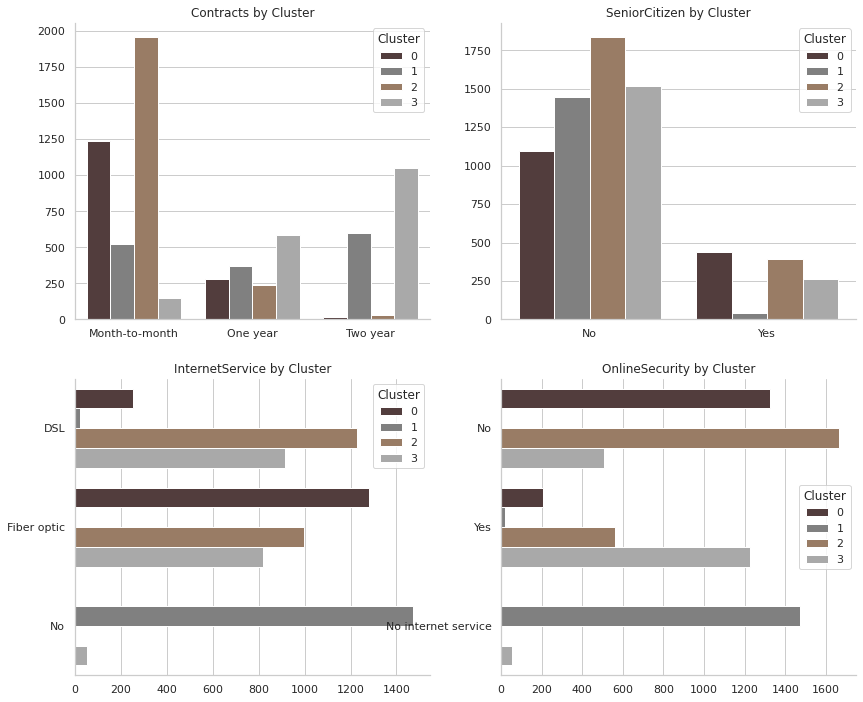

In [74]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,12))
sn.despine()

# Gray for No Churn, highlight Churn!
colors = ["#553939", "#808080", "#A27B5C","#A9A9A9"]
# Set custom color palette
sn.set_palette(sn.color_palette(colors))
ax = sn.countplot(x="Contract", hue="Cluster", data=df, ax = axes[0,0]).set(title='Contracts by Cluster', xlabel=None, ylabel = None)
ax = sn.countplot(x="SeniorCitizen", hue="Cluster", data=df, ax = axes[0,1]).set(title='SeniorCitizen by Cluster', xlabel=None, ylabel = None)
ax = sn.countplot(y='InternetService', hue="Cluster", data=df,ax = axes[1,0]).set(title='InternetService by Cluster', xlabel=None, ylabel = None)
ax = sn.countplot(y='OnlineSecurity', hue="Cluster", data=df, ax = axes[1,1]).set(title='OnlineSecurity by Cluster', xlabel=None, ylabel = None)
sn.despine()





<span style="font-family:serif;"> *Clusters 0 and 2 are typically* <span style="font-family:serif;">-
- <span style="font-family:serif;"> in the **Month - to Month Contract** <span style="font-family:serif;">
- <span style="font-family:serif;"> More likely to be **elderly** <span style="font-family:serif;">
- <span style="font-family:serif;"> Does **not have Online Security** <span style="font-family:serif;">
- <span style="font-family:serif;"> Uses **Fiber optic** <span style="font-family:serif;">


<div class="alert alert-block alert-info">
    <span style="font-size:18px;"> 
<b>In Conclusion:</b> Cluster analysis is helpful for placing customers into segments using data, which allow businesses to decide which segment(s) to target form distinct marketing mixs that will satisfy the needs and wants of each targeted Cluster.
</div>
    </span>

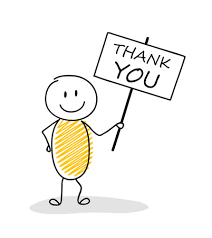